<a href="https://colab.research.google.com/github/stevengregori92/NLP-with-Neural-Network/blob/main/Hate_Speech_with_RNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **IMPORT DATASET**

In [1]:
! gdown https://drive.google.com/uc?id=15ZeT7KYtsneqgu8FUQPIvzH_DJEl4GYd &> /dev/null
! unzip 572-hate-speech-dataset.zip &> /dev/null
! rm -r 572-hate-speech-dataset.zip &> /dev/null

# **IMPORT LIBRARY AND PACKAGES**

In [2]:
import nltk
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [3]:
import re
import string
import pickle

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM
from tensorflow.keras.utils import pad_sequences

from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from string import punctuation
from nltk.stem import WordNetLemmatizer

sw_indo = stopwords.words('indonesian') + list(punctuation)

# **CONCAT DATASET**

In [5]:
df1 = pd.read_csv("/content/dataset_combined (1).csv", encoding='latin-1')
df1['class'].replace({"HS":1, "Not_HS": 0, 'NotHS':0}, inplace=True)
df1.head()

,class,comment_text
0,1,<USERNAME> TOLOL!! Gak ada hubungan nya kegug...
1,1,Geblek lo tata...cowo bgt dibela2in balikan......
2,1,Kmrn termewek2 skr lengket lg duhhh kok labil ...
3,1,"Intinya kalau kesel dengan ATT nya, gausah ke ..."
4,1,"hadewwwww permpuan itu lg!!!!sakit jiwa,knp ha..."


In [6]:
df2 = pd.read_csv("/content/572-hate-speech-dataset.csv", encoding='latin-1')
df2['class'].replace({"HS":1, "Not_HS": 0, 'NotHS':0}, inplace=True)
df2.head()

,comment_text,class
0,@david.wood17 knp lo gak berani bersumpah dan ...,1
1,"haha, somad somad. Muka dekil otak 0% , kok ya...",1
2,"hahaha, kaum sableng 212 kl berita begini mrk ...",1
3,"hahaha, makin stress aja ni umat sableng, dlu...",1
4,HIDUP PSI = partai SAMPAH indonesia..... ...,1


In [7]:
df = pd.concat([df1, df2])
df

,class,comment_text
0,1,<USERNAME> TOLOL!! Gak ada hubungan nya kegug...
1,1,Geblek lo tata...cowo bgt dibela2in balikan......
2,1,Kmrn termewek2 skr lengket lg duhhh kok labil ...
3,1,"Intinya kalau kesel dengan ATT nya, gausah ke ..."
4,1,"hadewwwww permpuan itu lg!!!!sakit jiwa,knp ha..."
...,...,...
567,0,@dedijunaidi212 'afwan ya akhi...
568,0,Aamiin.. Yaa Rahman.. Yaa Rahiim..
569,0,Siaaap.... GERAK..!!!
570,0,Bkan polisi yg bilang gila tapi saksi ahli.


In [8]:
df['class'].value_counts()

class
1    772
0    772
Name: count, dtype: int64

# **PREPROCESSING**

In [10]:
urlPattern = r"((http://)[^ ]*|(https://)[^ ]*|( www\.)[^ ]*)"
userPattern = '@[^\s]+'
def process_tweets(tweet):
    tweet = tweet.lower()
    tweet=tweet[1:]
    tweet = re.sub(urlPattern,'',tweet)
    tweet = re.sub(userPattern,'', tweet)
    tweet = tweet.translate(str.maketrans("","",string.punctuation))
    tokens = word_tokenize(tweet)
    final_tokens = [w for w in tokens if w not in sw_indo]
    wordLemm = WordNetLemmatizer()
    finalwords=[]
    for w in final_tokens:
      if len(w)>1:
        word = wordLemm.lemmatize(w)
        finalwords.append(word)
    return ' '.join(finalwords)

In [11]:
df['comment_text'] = df['comment_text'].apply(lambda x: process_tweets(x))
print('Text Preprocessing complete.')

Text Preprocessing complete.


In [12]:
X = np.array(df["comment_text"].values)
y = np.array(df["class"].values)

# **TOKENISASI**

In [13]:
max_words = 5000
max_len = 200

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(X)
sequences = tokenizer.texts_to_sequences(X)
tweets = pad_sequences(sequences, maxlen=max_len)

In [14]:
X_train, X_test, y_train, y_test = train_test_split(tweets, y, test_size=0.2, random_state=101)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((1235, 200), (309, 200), (1235,), (309,))

# **MODEL ARCHETECT**

In [15]:
embeded_vector_size = 35

model = Sequential([
    Embedding(max_words, embeded_vector_size,input_length=max_len),
    LSTM(64,dropout=0.5),
    Dense(16, activation='relu'),
    Dense(8, activation='relu'),
    Dense(1,activation='sigmoid')
])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 200, 35)           175000    
                                                                 
 lstm (LSTM)                 (None, 64)                25600     
                                                                 
 dense (Dense)               (None, 16)                1040      
                                                                 
 dense_1 (Dense)             (None, 8)                 136       
                                                                 
 dense_2 (Dense)             (None, 1)                 9         
                                                                 
Total params: 201785 (788.22 KB)
Trainable params: 201785 (788.22 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


# **TRAINING**

In [16]:
model.compile(
    loss='binary_crossentropy',
    optimizer="adam",
    metrics=["accuracy"],
)

history = model.fit(
  X_train, y_train, validation_data=(X_test, y_test), epochs=10, verbose=2
)

Epoch 1/10
39/39 - 12s - loss: 0.6938 - accuracy: 0.5028 - val_loss: 0.6904 - val_accuracy: 0.7605 - 12s/epoch - 297ms/step
Epoch 2/10
39/39 - 4s - loss: 0.6573 - accuracy: 0.7449 - val_loss: 0.5769 - val_accuracy: 0.7217 - 4s/epoch - 110ms/step
Epoch 3/10
39/39 - 3s - loss: 0.3656 - accuracy: 0.9012 - val_loss: 0.2766 - val_accuracy: 0.8900 - 3s/epoch - 74ms/step
Epoch 4/10
39/39 - 4s - loss: 0.1002 - accuracy: 0.9692 - val_loss: 0.2148 - val_accuracy: 0.9094 - 4s/epoch - 94ms/step
Epoch 5/10
39/39 - 2s - loss: 0.0320 - accuracy: 0.9911 - val_loss: 0.2097 - val_accuracy: 0.9159 - 2s/epoch - 60ms/step
Epoch 6/10
39/39 - 3s - loss: 0.0330 - accuracy: 0.9903 - val_loss: 0.2485 - val_accuracy: 0.9288 - 3s/epoch - 65ms/step
Epoch 7/10
39/39 - 2s - loss: 0.0143 - accuracy: 0.9960 - val_loss: 0.2325 - val_accuracy: 0.9288 - 2s/epoch - 52ms/step
Epoch 8/10
39/39 - 2s - loss: 0.0109 - accuracy: 0.9976 - val_loss: 0.2314 - val_accuracy: 0.9223 - 2s/epoch - 52ms/step
Epoch 9/10
39/39 - 2s - loss

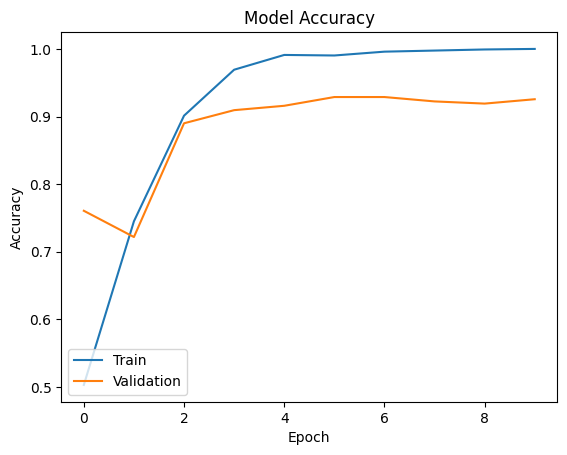

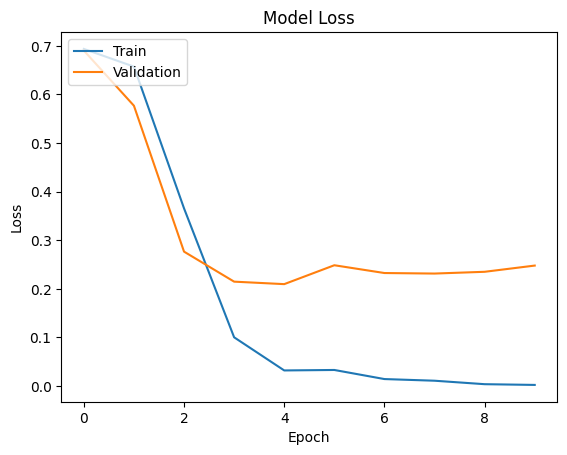

In [17]:
# Plot accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='lower left')
plt.show()

# Plot loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


#Predict

In [18]:
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences

def preprocess_text(text, tokenizer, max_len):
    # Apply the same preprocessing steps as in process_tweets function
    text = text.lower()
    text = re.sub(urlPattern, '', text)
    text = re.sub(userPattern, '', text)
    text = text.translate(str.maketrans("", "", string.punctuation))
    tokens = word_tokenize(text)
    final_tokens = [w for w in tokens if w not in sw_indo]
    wordLemm = WordNetLemmatizer()
    finalwords = [wordLemm.lemmatize(w) for w in final_tokens if len(w) > 1]
    processed_text = ' '.join(finalwords)


    sequence = tokenizer.texts_to_sequences([processed_text])
    padded_sequence = pad_sequences(sequence, maxlen=max_len)
    return padded_sequence

def predict_hate_speech(texts, model, tokenizer, max_len):
    results = []
    for text in texts:
        processed_text = preprocess_text(text, tokenizer, max_len)
        prediction = model.predict(processed_text)[0][0]
        is_hate_speech = "Hate speech" if prediction > 0.5 else "Not hate speech"
        confidence = prediction if prediction > 0.5 else 1 - prediction
        results.append({
            'text': text,
            'prediction': is_hate_speech,
            'confidence': float(confidence)
        })
    return results


texts = ['buku ini jelek setengah mampus', 'muka lu kek sampah', 'dia baik banget']
results = predict_hate_speech(texts, model, tokenizer, max_len)

# Print the results
for result in results:
    print(f"Text: {result['text']}")
    print(f"Prediction: {result['prediction']}")
    print(f"Confidence: {result['confidence']:.2f}")
    print()

1/1 [==============================] - 0s 30ms/step
Text: buku ini jelek setengah mampus
Prediction: Hate speech
Confidence: 0.99

Text: muka lu kek sampah
Prediction: Hate speech
Confidence: 1.00

Text: dia baik banget
Prediction: Not hate speech
Confidence: 0.93

